In [1]:
import torch
import torch.nn as nn

from torchvision import transforms

from PIL import Image

In [2]:
# 인코더(Encoder) 정의
classification_vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

# 사전학습된 vgg network와 decoder network의 가중치를 실제 사용할 모델에 로드한다.
classification_vgg.eval()

classification_vgg.load_state_dict(torch.load("./vgg_normalised.pth"))

device = torch.device("cuda")
classification_vgg.to(device)

classification_vgg = nn.Sequential(*list(classification_vgg.children())[:31])


for p in classification_vgg.parameters():
    p.requires_grad = False

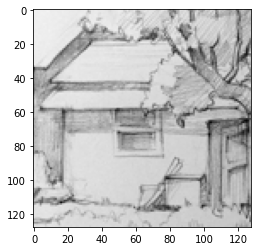

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 전처리 
# 흑백이여야 하지만 color shape은 3shape이여야 함.
image = Image.open("content.jpg").convert("L").resize((128, 128))
image = np.repeat(np.array(image), 3).reshape(128, 128, 3)
                  
plt.imshow(image/255.)

In [4]:
image = Image.fromarray(np.uint8(image)).convert("RGB")
image = transforms.Compose([transforms.ToTensor()])(image).to(device).unsqueeze(0)
print(image.size())

torch.Size([1, 3, 128, 128])


In [5]:
print(classification_vgg(image).size())

torch.Size([1, 512, 16, 16])


c:\users\simplepro\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        self.vgg = classification_vgg
        
        self.fc1 = nn.Linear(512 * 16 * 16, 100, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(100, 30, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
        self.fc3 = nn.Linear(30, 5, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        
        self.relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        out = self.vgg(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.relu(out)
        
        return out

In [7]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.data.shape)

(1797, 64)


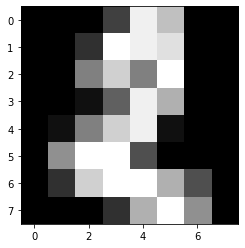

In [8]:
plt.imshow(digits.data[2].reshape(8, 8), cmap="gray")

In [9]:
def preprocessing(path):
    
    # 흑백이여야 하지만 color shape은 3shape이여야 함.
    image = Image.open(path).convert("L").resize((128, 128))
    image = np.repeat(np.array(image), 3).reshape(128, 128, 3)
    
    image = Image.fromarray(np.uint8(image)).convert("RGB")
    image = transforms.Compose([transforms.ToTensor()])(image).unsqueeze(0)

    return image

In [43]:
import os

abstract_dir = os.listdir("./dataset/abstract")
cityscape_dir = os.listdir("./dataset/cityscape")
landscape_dir = os.listdir("./dataset/landscape")
portrait_dir = os.listdir("./dataset/portrait")
still_life_dir = os.listdir("./dataset/still-life")

In [44]:
abstract_y = np.array([0 for i in range(len(abstract_dir))])
cityscape_y = np.array([1 for i in range(len(cityscape_dir))])
landscape_y = np.array([2 for i in range(len(landscape_dir))])
portrait_y = np.array([3 for i in range(len(portrait_dir))])
still_life_y = np.array([4 for i in range(len(still_life_dir))])

In [45]:
Y = np.concatenate((abstract_y, cityscape_y, landscape_y, portrait_y, still_life_y))

print(Y.shape)

(15000,)


In [46]:
X = torch.zeros((15000, 3, 128, 128))

for i in range(len(abstract_dir)):
    X[i] = preprocessing(f"./dataset/abstract/{abstract_dir[i]}")

In [47]:
print(i)

for i in range(len(cityscape_dir)):
    X[3000 + i] = preprocessing(f"./dataset/cityscape/{cityscape_dir[i]}")

2999


In [48]:
for i in range(len(landscape_dir)):
    X[6000+i] = preprocessing(f"./dataset/landscape/{landscape_dir[i]}")

In [49]:
for i in range(len(portrait_dir)):
    X[9000+i] = preprocessing(f"./dataset/portrait/{portrait_dir[i]}")

In [50]:
for i in range(len(still_life_dir)):
    X[12000+i] = preprocessing(f"./dataset/still-life/{still_life_dir[i]}")

In [51]:
print(X.size())

torch.Size([15000, 3, 128, 128])


In [52]:
Y = torch.tensor(Y, dtype=torch.int64)

In [53]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

In [54]:
from torch.optim import Adam

art_classification = Classification().to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer = Adam(art_classification.parameters(), lr=0.002)

total_batch = len(dataloader)
print(total_batch)

250


In [55]:
for epoch in range(10):
    avg_loss = 0
    
    for X, Y in dataloader:
        Y = Y.to(device)
        X = X.to(device)
        
        optimizer.zero_grad()
        pred = art_classification(X)
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
        
    avg_loss /= 15000
    print(f"epoch: {epoch}, avg_loss: {avg_loss}")

epoch: 0, avg_loss: 0.3223418891429901
epoch: 1, avg_loss: 0.07284219563007355
epoch: 2, avg_loss: 0.034746769815683365
epoch: 3, avg_loss: 0.021697957068681717
epoch: 4, avg_loss: 0.009887054562568665
epoch: 5, avg_loss: 0.0059075914323329926
epoch: 6, avg_loss: 0.003110970137640834
epoch: 7, avg_loss: 0.0029318395536392927
epoch: 8, avg_loss: 0.003144360613077879
epoch: 9, avg_loss: 0.0045781806111335754


In [56]:
print("state dict")
for param_tensor in art_classification.state_dict():
    print(f"{param_tensor}: {art_classification.state_dict()[param_tensor].size()}")

state dict
vgg.0.weight: torch.Size([3, 3, 1, 1])
vgg.0.bias: torch.Size([3])
vgg.2.weight: torch.Size([64, 3, 3, 3])
vgg.2.bias: torch.Size([64])
vgg.5.weight: torch.Size([64, 64, 3, 3])
vgg.5.bias: torch.Size([64])
vgg.9.weight: torch.Size([128, 64, 3, 3])
vgg.9.bias: torch.Size([128])
vgg.12.weight: torch.Size([128, 128, 3, 3])
vgg.12.bias: torch.Size([128])
vgg.16.weight: torch.Size([256, 128, 3, 3])
vgg.16.bias: torch.Size([256])
vgg.19.weight: torch.Size([256, 256, 3, 3])
vgg.19.bias: torch.Size([256])
vgg.22.weight: torch.Size([256, 256, 3, 3])
vgg.22.bias: torch.Size([256])
vgg.25.weight: torch.Size([256, 256, 3, 3])
vgg.25.bias: torch.Size([256])
vgg.29.weight: torch.Size([512, 256, 3, 3])
vgg.29.bias: torch.Size([512])
fc1.weight: torch.Size([100, 131072])
fc1.bias: torch.Size([100])
fc2.weight: torch.Size([30, 100])
fc2.bias: torch.Size([30])
fc3.weight: torch.Size([5, 30])
fc3.bias: torch.Size([5])


y label: cityscape, 	 predict label: cityscape


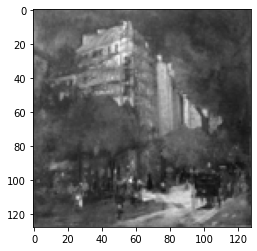

y label: cityscape, 	 predict label: cityscape


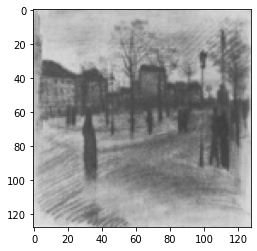

y label: still-life, 	 predict label: still-life


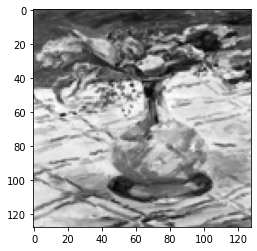

y label: cityscape, 	 predict label: cityscape


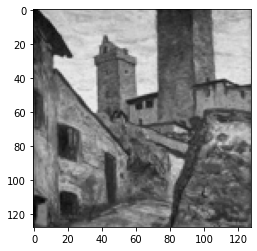

y label: still-life, 	 predict label: still-life


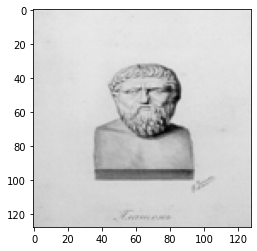

y label: portrait, 	 predict label: portrait


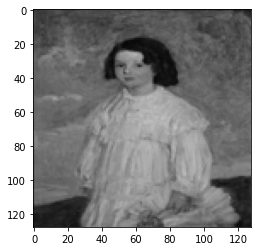

y label: landscape, 	 predict label: landscape


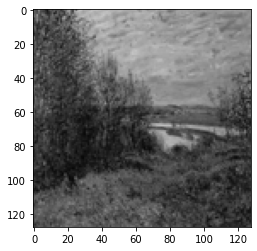

y label: still-life, 	 predict label: still-life


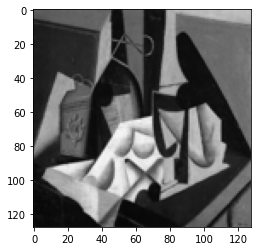

y label: still-life, 	 predict label: still-life


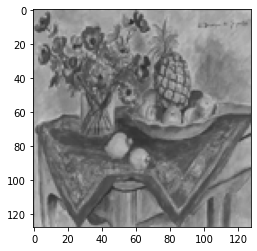

y label: abstract, 	 predict label: abstract


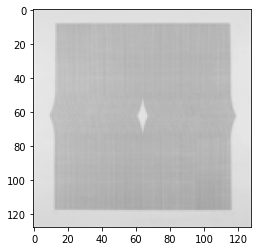

In [85]:
label_dir = {0: "abstract", 1:"cityscape", 2:"landscape", 3:"portrait", 4:"still-life"}

for x, y in zip(X[:10], Y[:10]):
    predict = torch.argmax(art_classification(x.unsqueeze(0))).item()
    print(f"y label: {label_dir[y.item()]}, \t predict label: {label_dir[predict]}")
    plt.imshow(x[0].cpu().detach().numpy().repeat(3).reshape(128, 128, 3))
    plt.show()

In [86]:
torch.save(art_classification.state_dict(), "./art_classification.pkl")

In [89]:
model = Classification()
model.load_state_dict(torch.load("./art_classification.pkl"))
model.cuda()

Classification(
  (vgg): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): ReflectionPad2d((1, 1, 1, 1))
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
    (15): ReflectionPad2d((1, 1, 1, 1))
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (17): ReLU()
    (18): ReflectionPad2d((1, 1, 1, 1))
    (19): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (20): ReLU()
    (21):

y label: cityscape, 	 predict label: cityscape


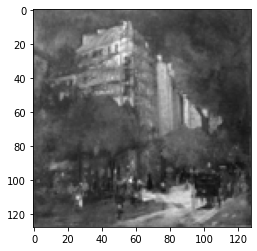

y label: cityscape, 	 predict label: cityscape


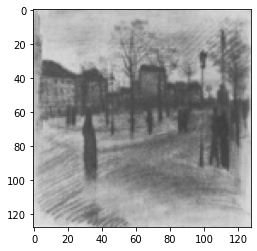

y label: still-life, 	 predict label: still-life


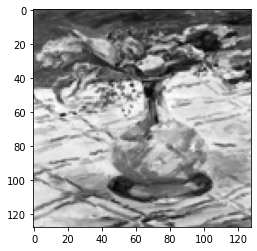

y label: cityscape, 	 predict label: cityscape


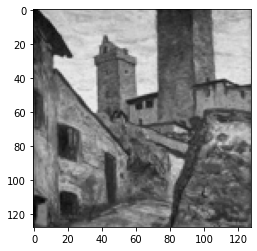

y label: still-life, 	 predict label: still-life


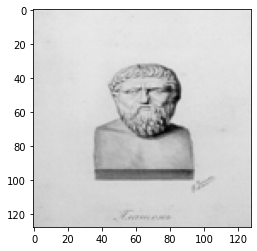

y label: portrait, 	 predict label: portrait


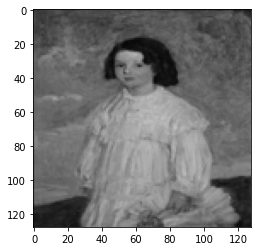

y label: landscape, 	 predict label: landscape


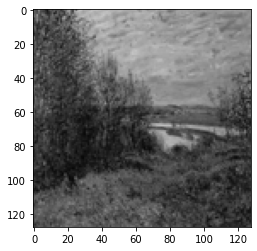

y label: still-life, 	 predict label: still-life


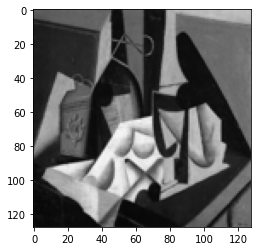

y label: still-life, 	 predict label: still-life


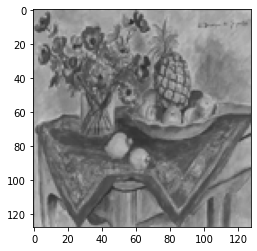

y label: abstract, 	 predict label: abstract


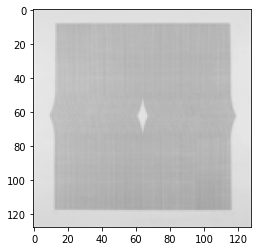

In [90]:
label_dir = {0: "abstract", 1:"cityscape", 2:"landscape", 3:"portrait", 4:"still-life"}

for x, y in zip(X[:10], Y[:10]):
    predict = torch.argmax(model(x.unsqueeze(0))).item()
    print(f"y label: {label_dir[y.item()]}, \t predict label: {label_dir[predict]}")
    plt.imshow(x[0].cpu().detach().numpy().repeat(3).reshape(128, 128, 3))
    plt.show()